This notebook is for exploring tensorflow basics; tensors, variables, autograd, graphs/functions, modules/layers/modules

A tensor (tf.constant) is an immutable multi-dimensional array, optimized for GPU processing

A variable (tf.variable) is a mutable tensor

Autograd computes the gradients of variables automatically; you first record operations on a GradientTape. Autograd then allows you to find the gradient of any of the input tensors with respect to a computed value, after recording the operations on the GradientTape.

A function (tf.function) is an efficient way to process tensorts. Tensorflow can execute a tf.Graph, which is an efficient DAG for performing tf.Operations (internal nodes) on tf.Tensors (inputs) to produce a single tf.Tensor (output). Graphs are created from Python code, but don't require the Python runtime and are much more efficient. The object model, per https://www.tensorflow.org/guide/function, is:
* tf.function wraps a Python function, returning a Function object
* A Function manages a cache of ConcreteFunctions and picks the most specific match based on the signature of inputs, or performs tracing to create a tfGraph and wrap it in a ConcreteFunction if there is no match
* A ConcreteFunction wraps a tf.Graph
* A tf.Graph is the raw, language-agnostic, portable representation of a TensorFlow computation
Tracing captures the tensorflow operations into a graph, converts some python code (e.g., numpy operations) into tensorflow first, and discards other operations like "print" statements. By default a Function will execute a graph if it can. A tf.function can also run "eagerly", where it executes the underlying python code rather than the graph.

A Model is a series of Layers. Both Models and Layers are typically implemented as subclasses of tf.Module, which is a container of tf.Variables (trainable parameters) and other tf.Modules (layers).

In practice, one normally uses Keras. The tf.keras.layers.Layer subclasses tf.Module and adds a lot of functionality. That is a topic for another notebook.

In [1]:
import tensorflow as tf
import timeit
from datetime import datetime
from os import listdir, remove

A tensor (tf.constant) is an immutable multi-dimensional array, optimized for GPU processing

In [2]:
# Tensor basics

# A 2x2 matrix
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])

# A 2x1 variable
b = tf.constant([[1.0], [2.0]])

c = a @ b
print (f"{a} @ {b} = {c}")
print (f"Dimensions of c: {c.shape}")
print (f"Type of c: {c.dtype}")

c = tf.Variable(c)


[[1. 2.]
 [3. 4.]] @ [[1.]
 [2.]] = [[ 5.]
 [11.]]
Dimensions of c: (2, 1)
Type of c: <dtype: 'float32'>


A variable (tf.variable) is a mutable tensor

In [3]:
# Variable basics - just like tensors, but can be modified

a = tf.Variable([2.0, 3.0])
print (f"a = {a}")
print (f"type of a: {a.dtype}")

# Reassigning values doesn't change the dtype
a.assign([1, 2])
print (f"a = {a}")
print (f"type of a: {a.dtype}")

# Note: You can't assign a new shape - only modify values

a = <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([2., 3.], dtype=float32)>
type of a: <dtype: 'float32'>
a = <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>
type of a: <dtype: 'float32'>


Autograd computes the gradients of variables automatically; you first record operations on a GradientTape. Autograd then allows you to find the gradient of any of the input tensors with respect to a computed value, after recording the operations on the GradientTape.

In [4]:
# Autograd allows you to compute gradients of input tensorts wrt output tensors automatically

w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

# Note, the 2nd parameter can be an iterable (list, dictionary, etc), and the gradients will be computed for each element
# and returned as the same iterable type
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

print (f"dl_dw = {dl_dw}")
print (f"dl_db = {dl_db}")

# Note: By default, only tf.Variable objects are recorded in the tape. To record tensors, you must use tape.watch()
# You can mark a tf.Variable as untrainable by setting trainable=False
x0 = tf.Variable(3.0, name='x0')                  # A trainable variable
x1 = tf.Variable(3.0, name='x1', trainable=False) # Not trainable
x2 = tf.Variable(2.0, name='x2') + 1.0            # Not a Variable: A variable + tensor returns a tensor.
x3 = tf.constant(3.0, name='x3')                  # Not a Variable

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:  # So only the first gradient is computed
  print(g)

# Apply the gradient to x0 (the only trainable variable)
print ("x0 before applying gradient:", x0)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
optimizer.apply_gradients(zip(grad, [x0]))
print ("x0 after:", x0)

# Note: In practice, you'll train Modules (more on those later), which specify what is trainable in Module.trainable_variables

dl_dw = [[10.599808   -0.42668438]
 [21.199615   -0.85336876]
 [31.799423   -1.2800531 ]]
dl_db = [10.599808   -0.42668438]
tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None
x0 before applying gradient: <tf.Variable 'x0:0' shape=() dtype=float32, numpy=3.0>
x0 after: <tf.Variable 'x0:0' shape=() dtype=float32, numpy=2.4>


A function (tf.function) is an efficient way to process tensorts. Tensorflow can execute a tf.Graph, which is an efficient DAG for performing tf.Operations (internal nodes) on tf.Tensors (inputs) to produce a single tf.Tensor (output). Graphs are created from Python code, but don't require the Python runtime and are much more efficient. The object model, per https://www.tensorflow.org/guide/function, is:
* tf.function wraps a Python function, returning a Function object
* A Function manages a cache of ConcreteFunctions and picks the most specific match based on the signature of inputs, or performs tracing to create a tfGraph and wrap it in a ConcreteFunction if there is no match
* A ConcreteFunction wraps a tf.Graph
* A tf.Graph is the raw, language-agnostic, portable representation of a TensorFlow computation
Tracing captures the tensorflow operations into a graph, converts some python code (e.g., numpy operations) into tensorflow first, and discards other operations like "print" statements. By default a Function will execute a graph if it can. A tf.function can also run "eagerly", where it executes the underlying python code rather than the graph.

In [5]:
# One way to declare a Function is with a decorator
@tf.function
def add (x, y):
    print (x, y)
    return x+y

# Let's see it execute eagerly and in graph model
print ("This should print output, due to tracing")
a = tf.Variable(1)
b = tf.Variable(2)
af = tf.Variable(1.)
bf = tf.Variable(2.)
assert (add (a, b) == 3)

print ("No output, since the Function now has a cached graph")
assert (add (a, b) == 3)

print ("This should print output, since it's being called with a different signature")
assert (add (af, bf) == 3.0)


This should print output, due to tracing
<tf.Variable 'Variable:0' shape=() dtype=int32> <tf.Variable 'Variable:0' shape=() dtype=int32>
No output, since the Function now has a cached graph
This should print output, since it's being called with a different signature
<tf.Variable 'Variable:0' shape=() dtype=float32> <tf.Variable 'Variable:0' shape=() dtype=float32>


In [6]:
# Graph execution is much faster if there are many small functions, like below
# Less so if there are few large functions
x = tf.random.uniform(shape=[10, 10], minval=-1, maxval=2, dtype=tf.dtypes.int32)

def power(x, y):
  result = tf.eye(10, dtype=tf.dtypes.int32)
  for _ in range(y):
    result = tf.matmul(x, result)
  return result

print("Regular function execution:", timeit.timeit(lambda: power(x, 100), number=1000), "seconds")

# You can force a Function to execute eagerly for test purposes
power_as_graph = tf.function(power)
print("tf.function execution:", timeit.timeit(lambda: power_as_graph(x, 100), number=1000), "seconds")

# You can force a Function to execute eagerly for test purposes
tf.config.run_functions_eagerly(True)
print("tf.function executing eagerly:", timeit.timeit(lambda: power_as_graph(x, 100), number=1000), "seconds")
tf.config.run_functions_eagerly(False)

Regular function execution: 4.515885799999523 seconds
tf.function execution: 0.5299015000000509 seconds
tf.function executing eagerly: 4.4781708000000435 seconds



A Model is a series of Layers. Both Models and Layers are typically implemented as subclasses of tf.Module, which is a container of tf.Variables (trainable parameters) and other tf.Modules (layers).
Models have the following common properties:
* submodules - collection of submodules
* variables/trainable_variables/non_trainable_variables - uses reflection, so not very performant
Variables can be marked trainable or non-trainable when declared, as well as via the Model.trainable_variables property

If the __call__ method is a tf.Function, then the model will generate tf.Graphs for faster execution and can be saved and run without Python.

In [7]:
class DenseLayer(tf.Module):
  def __init__(self, input_dim, output_dim, name=None):
    super().__init__(name=name)
    self.w = tf.Variable(
      tf.random.normal([input_dim, output_dim]), name='w')
    self.b = tf.Variable(tf.zeros([output_dim]), name='b', dtype=tf.float32)
    self.u = tf.Variable(tf.zeros([output_dim]), name='u', trainable=False, dtype=tf.float32) # Just to show how to make a non-trainable variable
  def __call__(self, x):
    y = tf.matmul(x, self.w) + self.b + self.u
    return tf.nn.relu(y)
  
d = DenseLayer(input_dim=3, output_dim=2)
d(tf.ones([1, 3]))
print (d.trainable_variables)
print (d.non_trainable_variables)

class MySequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = DenseLayer(input_dim=3, output_dim=3)
    self.dense_2 = DenseLayer(input_dim=3, output_dim=2)

  @ tf.function
  def __call__(self, x):
    x = self.dense_1(x)
    return self.dense_2(x)

# You have made a model with two layers
my_model = MySequentialModule(name="the_model")

# Call it, with random results
print("Model results:", my_model(tf.constant([[2.0, 2.0, 2.0]])))

print("Submodules:", my_model.submodules)

for var in my_model.variables:
  print(var, "\n")

(<tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>, <tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[-0.4350437 , -0.20143096],
       [ 1.0099665 ,  0.6100367 ],
       [-0.00163661, -0.7615811 ]], dtype=float32)>)
(<tf.Variable 'u:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,)
Model results: tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)
Submodules: (<__main__.DenseLayer object at 0x00000248CCFC4430>, <__main__.DenseLayer object at 0x00000248CCFC4BB0>)
<tf.Variable 'b:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)> 

<tf.Variable 'u:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)> 

<tf.Variable 'w:0' shape=(3, 3) dtype=float32, numpy=
array([[-0.32772034, -1.0103503 , -0.7136852 ],
       [-0.15748464, -0.02599654,  0.75895697],
       [-0.12675129,  0.7697103 , -0.48888776]], dtype=float32)> 

<tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=fl

Modules can be checkpointed. Checkpointing allows you to save the weights so you can resume training later. Checkpointing consist of two kinds of files: the data itself and an index file for metadata. The index file keeps track of what is actually saved and the numbering of checkpoints, while the checkpoint data contains the variable values and their attribute lookup paths.

In [8]:
print("Original model results:", my_model(tf.constant([[1.0, 2.0, 3.0]])))
chkp_path = "data/models/my_checkpoint"
checkpoint = tf.train.Checkpoint(model=my_model)
checkpoint.write(chkp_path)

# Inspect the checkpoint
tf.train.list_variables(chkp_path)

# When you load the model back in, you overwrite the values in the existing model
new_model = MySequentialModule(name="restored_model")
new_checkpoint = tf.train.Checkpoint(model=new_model)
new_checkpoint.restore(chkp_path)

# Should be the same result as above
print ("Restored model results:", new_model(tf.constant([[1.0, 2.0, 3.0]])))

Original model results: tf.Tensor([[0.3767302 1.440889 ]], shape=(1, 2), dtype=float32)
Restored model results: tf.Tensor([[0.3767302 1.440889 ]], shape=(1, 2), dtype=float32)


Models can be saved and loaded

In [9]:
# Since __call__ has been defined as a tf.function, it will generate a graph we can visualize within a TensorBoard summary

# First set up logging after clearing prior logs
logdir = "logs/tensorboard_test"
for file in listdir(logdir):
  remove(logdir + "/" + file)
writer = tf.summary.create_file_writer(logdir)

# Create a new model to get a fresh trace, otherwise the summary will not see the graph.
new_model = MySequentialModule()

# Bracket the function call with tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True)
z = print(new_model(tf.constant([[2.0, 2.0, 2.0]])))
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

# View the output in TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/tensorboard_test

tf.Tensor([[0.       2.221099]], shape=(1, 2), dtype=float32)


Reusing TensorBoard on port 6006 (pid 9580), started 0:42:46 ago. (Use '!kill 9580' to kill it.)

A SavedModel is the recommended way of sharing trained models. A SavedModel contains both a collection of functions and a collection of weights

In [10]:
model_path = "data/models/saved_model"
tf.saved_model.save(my_model, model_path)

# Enumerate all files in the saved_model directory
print ("Files in the saved_model folder:", listdir(model_path))

# Load the model back in
restored_saved_model = tf.saved_model.load(model_path)

# Verify the restored model gives the same results
print ("Original model results:", my_model(tf.constant([[1.0, 2.0, 3.0]])))
print ("Restored model results:", restored_saved_model(tf.constant([[1.0, 2.0, 3.0]])))


INFO:tensorflow:Assets written to: data/models/saved_model\assets
Files in the saved_model folder: ['assets', 'fingerprint.pb', 'saved_model.pb', 'variables']
Original model results: tf.Tensor([[0.3767302 1.440889 ]], shape=(1, 2), dtype=float32)
Restored model results: tf.Tensor([[0.3767302 1.440889 ]], shape=(1, 2), dtype=float32)


Let's explore viewing a keras model's details after creating a couple of generic methods for image viewing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# A class for viewing images in a data set
class ImageViewer:
    """Display images from a data set a grid at a time, with next and prev buttons
    Optionally provide mislabled predictions to display as well"""

    def __init__ (self, x : np.ndarray, y : np.ndarray, label_names : str, rows : int = 5, cols : int = 5, \
                  figsize=(10,10), title : str = "Images"):
        """x - the data set, y - the labels, label_names - the names of the labels, rows, cols = grid to display at a time
          figsize - the size of each image in the grid"""
        self.ind = 0
        self.x = x
        self.y = y
        self.label_names = label_names
        self.rows = rows
        self.cols = cols
        self.title = title

        plt.figure(figsize=figsize)
        plt.margins(0, 0)

        self._draw_images()

        next_btn = plt.axes([0.7, 0.1, 0.1, 0.075])
        prev_btn = plt.axes([0.2, 0.1, 0.1, 0.075])
        self.next_button = plt.Button(next_btn, 'Next')
        self.prev_button = plt.Button(prev_btn, 'Prev')
        self.next_button.on_clicked(self._next)
        self.prev_button.on_clicked(self._prev)

        plt.show()

    def _draw_images(self):
        """Draw rows*cols images from the data set, starting at ind"""
        start_ix = self.ind * self.rows * self.cols
        end_ix = start_ix + self.rows * self.cols
        plt.suptitle(f"{self.title} {start_ix} - {end_ix}")

        for i in range(self.rows * self.cols):
            plt.subplot(self.rows + 1, self.cols, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(self.x[self.ind + i], cmap=plt.cm.get_cmap("binary"))
            plt.xlabel(self.label_names[self.y[self.ind + i]])
            plt.margins(0.1, 0.1)
        plt.draw()

    def _next(self, event):  # pylint: disable=unused-argument
        """Show the next set of images"""
        if self.ind * self.rows * self.cols < len(self.x):
            self.ind += 1
            self._draw_images()

    def _prev(self, event):  # pylint: disable=unused-argument
        """Show the previous set of images"""
        if self.ind > 0:
            self.ind -= 1
            self._draw_images()

def plot_training_history(history, figsize=(10,10)):
    """Plot loss and accuracy during training"""
    fig, (pa, pl) = plt.subplots(2, 1, figsize=figsize)
    plt.suptitle("Training History - accuracy and loss per epoch")

    pa.autoscale(enable=True, axis='y')
    pa.plot(history.history['accuracy'], label='Training Accuracy')
    pa.plot(history.history['val_accuracy'], label='Validation Accuracy')
    pa.legend(loc='lower right')
    pa.set_ylabel('Accuracy')
    pa.set_xlabel('Epoch')

    pl.autoscale(enable=True, axis='y')
    pl.plot(history.history['loss'], label='Training Loss')
    pl.plot(history.history['val_loss'], label='Validation Loss')
    pl.legend(loc='upper right')
    pl.set_ylabel('Loss')
    pl.set_xlabel('Epoch')

    plt.show()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 64)                50240     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
750/750 [==============================] - 3s 4ms/step - loss: 0.3537 - accuracy: 0.9007 - val_loss: 0.1844 - val_accuracy: 0.9468
Epoch 2/4
750/750 [=======================

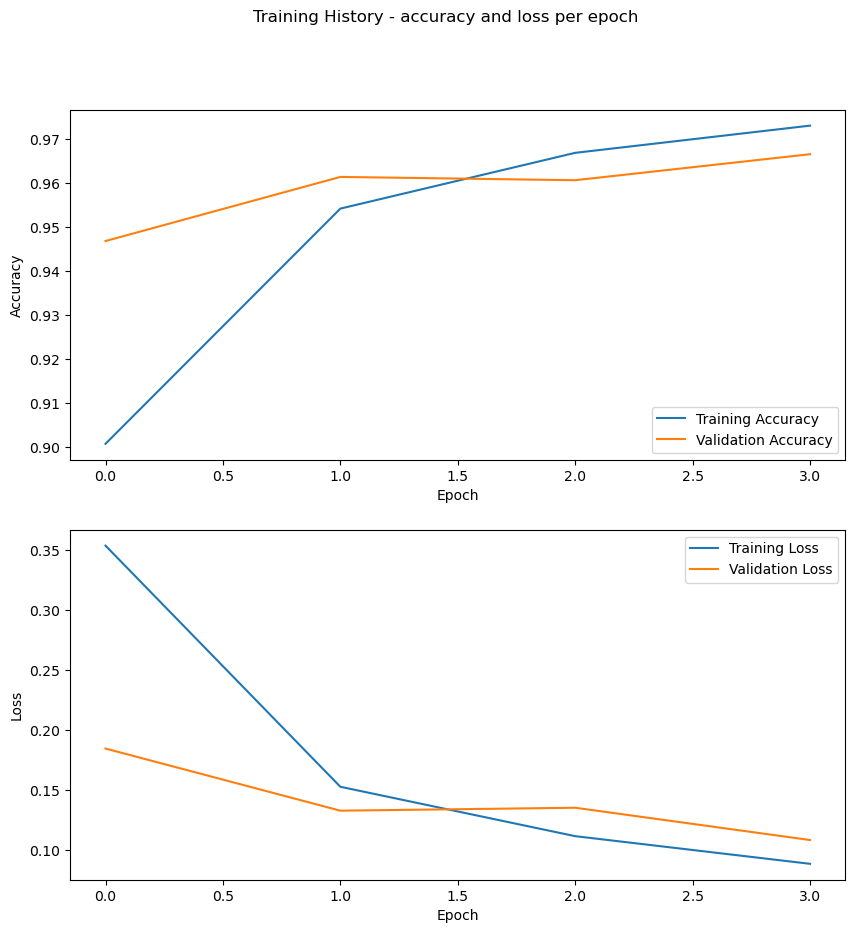

313/313 - 1s - loss: 0.0977 - accuracy: 0.9705 - 794ms/epoch - 3ms/step
Test loss: 0.10
Test accuracy: 97.05%

Confusion matrix
313/313 [==============================] - 0s 1ms/step
tf.Tensor(
[[ 964    1    1    0    1    4    3    2    1    3]
 [   0 1129    1    0    0    1    2    0    2    0]
 [   7    8  973    4    9    0    5   10   15    1]
 [   0    0    4  966    0   20    0    6   12    2]
 [   0    2    1    0  957    1    5    2    2   12]
 [   2    0    0    7    1  874    4    0    1    3]
 [   8    3    0    1    5    5  934    0    2    0]
 [   0    9    4    1    0    2    0 1004    1    7]
 [   4    1    3    7    4    7    3    4  937    4]
 [   3    5    0    7   13    4    1    7    2  967]], shape=(10, 10), dtype=int32)


C:\Users\marcs\AppData\Local\Temp\ipykernel_17004\1301917373.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(self.rows + 1, self.cols, i+1)
C:\Users\marcs\AppData\Local\Temp\ipykernel_17004\1301917373.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(self.x[self.ind + i], cmap=plt.cm.get_cmap("binary"))


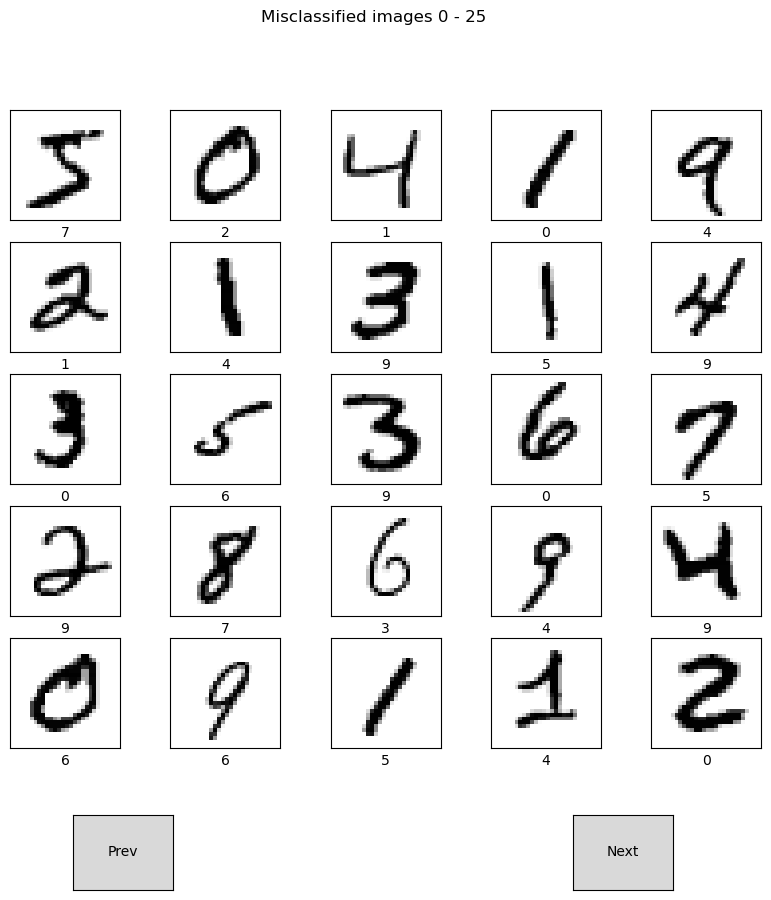

tf.Tensor(
[[ 0.3555842   0.12690811 -0.26367593 -0.03689115  0.32097688 -0.10729685
  -0.29340813 -0.15685359  0.36333075  0.04639856]], shape=(1, 10), dtype=float32)


Reusing TensorBoard on port 6006 (pid 9072), started 1 day, 21:56:08 ago. (Use '!kill 9072' to kill it.)

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from os import listdir, remove

def get_model():
  inputs = keras.Input(shape=(784,), name="input")
  x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
  x = layers.Dense(64, activation="relu", name="dense_2")(x)
  outputs = layers.Dense(10, name="predictions")(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

  model.compile(
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
  )

  return model

model = get_model()
model.summary()

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

history = model.fit(x_train, y_train, batch_size=64, epochs=4, validation_split=0.2)
plot_training_history(history)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print (f"Test loss: {test_scores[0]:.2f}")
print (f"Test accuracy: {test_scores[1] * 100:.2f}%")

print ("\nConfusion matrix")
y_pred = model.predict(x_test).argmax(axis=1)
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
print (cm)

# Show misclassified images
bad_x = []
bad_y = []
for x, y, pred in zip(x_train, y_train, y_pred):
    if y != pred:
        bad_x.append(x.reshape(28,28))
        bad_y.append(pred)

class_names = [str(i) for i in range(10)]
ImageViewer(bad_x, bad_y, class_names, title="Misclassified images")

# Show model in TensorBoard
# First set up logging after clearing prior logs
logdir = "logs/tensorboard_test"
for file in listdir(logdir):
  remove(logdir + "/" + file)
writer = tf.summary.create_file_writer(logdir)

# Create a new model to get a fresh trace, otherwise the summary will not see the graph.
model = get_model()

# Bracket the function call with tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True)
image = tf.reshape(x_test[0], (1, 784))
z = print(model(image))
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

# View the output in TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/tensorboard_test